# An example for  predicting the problem just using KNN

## Imports and data preparations

In [15]:
from __future__ import print_function    # (at top of module)
import warnings
warnings.filterwarnings('ignore')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types
from pandas.plotting import table
import six

In [16]:
# Read the data from the file
data = pd.read_csv('Data/data_500_entries_youtube.csv')
print("Number of entries in original data: " + str(len(data.index)))
data = data.sample(frac=1).reset_index(drop=True)
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5U28PY9MekLyCBYtLHGQpe,Meu Abrigo,[Melim],81,0.572,0.125,92.011,0.0304,0.2140,0.000000,4,0.658,3,231474,-7.527,0.741,1,88858322,Melim - Meu Abrigo
1,spotify:track:3JX0dOCIAiaR8MP3ryXWuM,What About Me (feat. Sosamann),"[Lil Wayne, Sosamann]",81,0.440,0.122,118.089,0.0401,0.0263,0.000002,4,0.784,10,216961,-6.566,0.220,1,165873,Lil Wayne - What About Me (Audio) Feat. Post M...
2,spotify:track:0O4XHiuVt3dBaOzSI49BtF,Bella,"[MHD, WizKid]",68,0.639,0.124,102.045,0.1250,0.4220,0.000000,4,0.767,6,183745,-6.633,0.653,0,70286858,MHD - Bella (feat. WizKid)
3,spotify:track:6rvSAESqueLmDe00pudWtr,Modalità Aereo (feat. Luchè & Marracash),"[Gue Pequeno, Luche, Marracash]",71,0.676,0.174,147.892,0.0789,0.1820,0.000005,4,0.737,6,190480,-5.018,0.656,1,626241,Modalità Aereo
4,spotify:track:2tE91SF5e1xY20syeIaKBh,LA VIDA LOCA,"[Jonna Fraser, SBMG]",68,0.702,0.137,104.966,0.2710,0.2390,0.000000,4,0.857,8,176226,-6.835,0.651,0,1021707,Jonna Fraser - LA VIDA LOCA ft. SBMG (prod. Jo...


In [17]:
# Features that we use
print(data.columns)

Index(['song_id', 'song_title', 'artist', 'popularity', 'energy', 'liveness',
       'tempo', 'speechiness', 'acousticness', 'instrumentalness',
       'time_signature', 'danceability', 'key', 'duration', 'loudness',
       'valence', 'mode', 'youtube_view_count', 'youtube_video_title'],
      dtype='object')


In [18]:
# Min, max, std, mean, count of the values of our features
data.describe()

,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,5.700000e+02
mean,76.496491,0.657613,0.177728,122.800695,0.130653,0.251484,0.010485,3.984211,0.702096,5.222807,202636.614035,-6.065332,0.521494,0.573684,7.596583e+07
std,8.981380,0.160919,0.155160,29.437194,0.107296,0.229787,0.072553,0.261327,0.131463,3.584458,39236.547458,2.197471,0.215014,0.494975,1.708684e+08
min,51.000000,0.093500,0.022200,64.934000,0.025600,0.000046,0.000000,1.000000,0.264000,0.000000,90933.000000,-15.662000,0.039000,0.000000,4.270000e+02
25%,70.000000,0.559000,0.091925,99.940250,0.048600,0.065825,0.000000,4.000000,0.618250,1.000000,181178.250000,-7.392000,0.357250,0.000000,3.028858e+06
50%,76.000000,0.675500,0.116000,120.695500,0.086250,0.186500,0.000000,4.000000,0.720500,6.000000,199442.000000,-5.823000,0.520000,1.000000,1.848132e+07
75%,83.000000,0.773750,0.197750,142.985750,0.188750,0.371000,0.000010,4.000000,0.797000,8.000000,219419.250000,-4.586000,0.699500,1.000000,7.062040e+07
max,100.000000,0.984000,0.985000,203.911000,0.530000,0.989000,0.905000,5.000000,0.975000,11.000000,417920.000000,-0.787000,0.960000,1.000000,1.956582e+09


Number of examples >= 50 popularity: 570-> 100.0%
Number of examples >= 60 popularity: 558-> 97.89473684210526%
Number of examples >= 70 popularity: 446-> 78.24561403508773%
Number of examples >= 80 popularity: 197-> 34.56140350877193%
Number of examples >= 90 popularity: 55-> 9.649122807017545%
Number of examples >= 100 popularity: 1-> 0.17543859649122806%


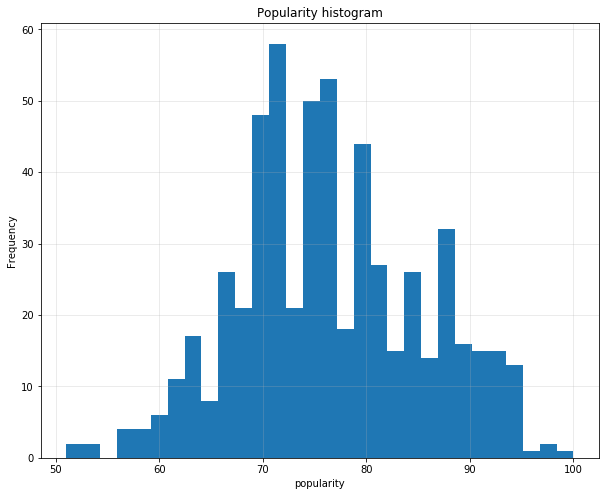

In [19]:
N = len(data.index)
d = len(data.columns) - 2
for i in range(50, 101, 10):
    no_examples = len(data[data.popularity >= i].index)
    per_examples = 100.0 * no_examples/N
    print("Number of examples >= " + str(i) 
          + " popularity: " + str(no_examples) 
          + "-> " + str(per_examples) +"%")
data['popularity'].plot.hist(bins=30, rwidth=10,figsize=(10,8))
plt.xlabel('popularity')
plt.title("Popularity histogram")
plt.grid(alpha=0.3)

In [20]:
# Label the data
from project_modules import *
final_data = label_data(data, 89)

Number of popular examples after thresholding :  55
Number of not popular examples after thresholding :  515


In [21]:
# Drop unnecessary columns
final_data.drop(['song_id', 'song_title', 'artist', 'popularity','youtube_view_count', 'youtube_video_title'], 1, inplace=True)

In [22]:
# X will be our examples and y will be our labels
X = np.array(final_data.drop('is_popular', axis=1))
y = np.array(final_data['is_popular'])
print(X)
print()
print()
print(y)

# SKLEARN DATASET
# from sklearn import datasets
# data = datasets.load_breast_cancer()
# X = np.array(data.data)
# y= np.array(data.target)
# print(X)

[[ 5.72000e-01  1.25000e-01  9.20110e+01 ... -7.52700e+00  7.41000e-01
   1.00000e+00]
 [ 4.40000e-01  1.22000e-01  1.18089e+02 ... -6.56600e+00  2.20000e-01
   1.00000e+00]
 [ 6.39000e-01  1.24000e-01  1.02045e+02 ... -6.63300e+00  6.53000e-01
   0.00000e+00]
 ...
 [ 8.01000e-01  1.43000e-01  1.30059e+02 ... -2.94200e+00  4.16000e-01
   0.00000e+00]
 [ 6.47000e-01  7.97000e-02  1.39787e+02 ... -3.79100e+00  5.31000e-01
   1.00000e+00]
 [ 6.11000e-01  3.50000e-02  1.84055e+02 ... -8.05700e+00  5.98000e-01
   0.00000e+00]]


[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1
 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0

In [23]:
from sklearn import preprocessing
COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
                    "speechiness", "acousticness", "instrumentalness", 
                    "time_signature", "danceability", "key", 
                    "duration", "loudness", "valence", "mode"]

# Keep data in a temp variable for testing
#scaled_data = scale_data_standardize(X, COLUMNS_TO_SCALE)
scaler = preprocessing.StandardScaler()
scaler.fit(X)

# Copy data back
X = scaler.transform(X)

#Just to check that everything is fine
X.mean(axis=0)

array([ 1.24656620e-17, -7.16775567e-17, -4.48763833e-16,  2.18149086e-17,
        9.97252962e-17, -1.55820775e-18, -6.73145750e-16,  7.94685954e-17,
        1.21540205e-16, -1.43355113e-16, -2.61778903e-16,  2.11916255e-16,
        4.36298171e-17])

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.model_selection import cross_val_score

In [25]:
# Calculate scores for every K value
k_range = list(range(1, 20, 2))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=KFold(n_splits=10), scoring='roc_auc')
    k_scores.append(scores.mean())
print(k_scores)

[0.5122429951661361, 0.4790574863230246, 0.5352889510908379, 0.580380315341747, 0.5950646818959805, 0.58516314369644, 0.5797067250944888, 0.5844464792206191, 0.595914533528296, 0.5871942290865708]


Text(0, 0.5, 'CV mean F1 score')

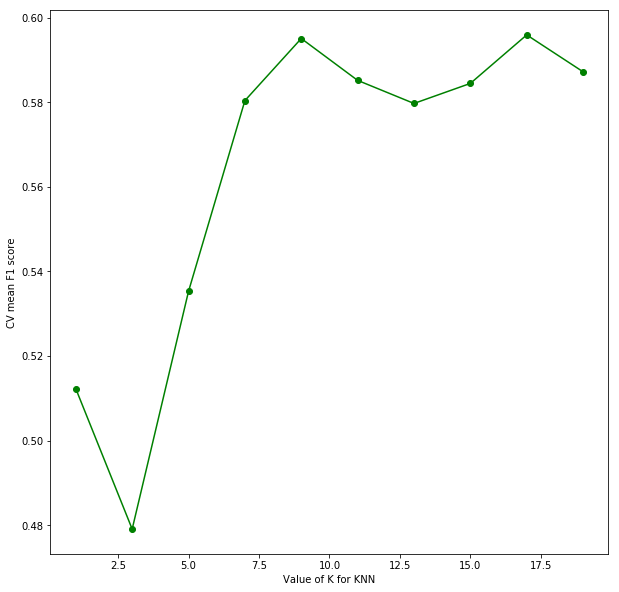

In [26]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores, 'go-')
plt.xlabel('Value of K for KNN')
plt.ylabel('CV mean F1 score')

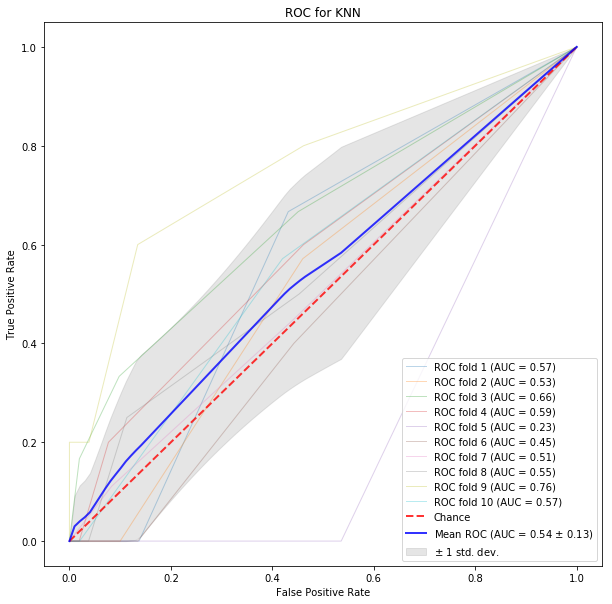

Accuracy mean:  0.9052631578947368

F1 mean:  0.8617969160257465


In [27]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
nbrs = KNeighborsClassifier(n_neighbors=6)
cv = KFold(n_splits=10)
X = np.array(X)
y = np.array(y)
tprs=[]
f1s = []
aucs=[]
accs=[]
i=0
mean_fpr = np.linspace(0, 1, 100)
for train, test in cv.split(X, y):
    probas_ = nbrs.fit(X[train], y[train]).predict_proba(X[test])
    predicts = nbrs.predict(X[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    conf_matrix = confusion_matrix(y[test], predicts)
    #roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y[test], probas_[:, 1], average="weighted")
    aucs.append(roc_auc)
    f1s.append(f1_score(y[test], predicts, average="weighted"))
    accs.append(accuracy_score(y[test], predicts))
    i += 1
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for KNN')
plt.legend(loc="lower right")
plt.show()

print("Accuracy mean: ",np.mean(accs))
print()
print("F1 mean: ", np.mean(f1s))